In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import tree
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
cuaca = pd.read_excel("Semarang.xlsx", parse_dates=['Tanggal'], index_col='Tanggal')
cuaca

,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car
Tanggal,,,,,,,,,,
2017-02-01,25.0,30.8,26.2,86.0,4.0,5.3,6.0,315.0,4.0,NW
2017-02-02,23.8,29.2,25.7,87.0,24.0,0.8,5.0,315.0,3.0,NW
2017-02-03,23.0,30.2,26.1,85.0,17.0,2.3,5.0,315.0,3.0,NW
2017-02-04,23.2,30.8,27.4,82.0,23.0,4.2,7.0,315.0,4.0,NW
2017-02-05,24.2,31.2,27.3,84.0,11.0,5.7,5.0,315.0,4.0,NW
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,26.0,34.0,30.9,69.0,2.2,2.3,6.0,340.0,2.0,N
2023-12-28,26.8,36.4,30.5,72.0,0.2,6.5,10.0,20.0,2.0,C
2023-12-29,25.4,36.0,31.5,69.0,12.2,6.5,4.0,40.0,2.0,C


In [ ]:
cuaca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2525 entries, 2017-02-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tn       2525 non-null   float64
 1   Tx       2525 non-null   float64
 2   Tavg     2525 non-null   float64
 3   RH_avg   2525 non-null   float64
 4   RR       2525 non-null   float64
 5   ss       2525 non-null   float64
 6   ff_x     2525 non-null   float64
 7   ddd_x    2525 non-null   float64
 8   ff_avg   2525 non-null   float64
 9   ddd_car  2387 non-null   object 
dtypes: float64(9), object(1)
memory usage: 217.0+ KB


In [ ]:
cuaca.isna().sum()

,0
Tn,0
Tx,0
Tavg,0
RH_avg,0
RR,0
ss,0
ff_x,0
ddd_x,0
ff_avg,0
ddd_car,138


In [ ]:
cuaca['ddd_car'].fillna(cuaca['ddd_car'].mode()[0], inplace=True)
cuaca.isna().sum()

<ipython-input-75-a20f95dd1736>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cuaca['ddd_car'].fillna(cuaca['ddd_car'].mode()[0], inplace=True)


,0
Tn,0
Tx,0
Tavg,0
RH_avg,0
RR,0
ss,0
ff_x,0
ddd_x,0
ff_avg,0
ddd_car,0


In [ ]:
cuaca.drop('ddd_car', axis=1, inplace=True)

In [ ]:
# Feature Engineering: Menambahkan fitur waktu
cuaca['Month'] = cuaca.index.month
cuaca['DayOfYear'] = cuaca.index.dayofyear
cuaca['DayOfWeek'] = cuaca.index.dayofweek

# Feature Engineering: Menambahkan fitur statistik berbasis waktu
cuaca['Tavg_7d'] = cuaca['Tavg'].rolling(window=7, min_periods=1).mean()
cuaca['RH_avg_7d'] = cuaca['RH_avg'].rolling(window=7, min_periods=1).mean()

# Feature Engineering: Interaksi variabel cuaca
cuaca['RH_RR_interaction'] = cuaca['RH_avg'] * cuaca['RR']

In [ ]:
def create_lags(cuaca, lags=30):
    for i in range(1, lags + 1):
        cuaca[f'lag_{i}'] = cuaca['Tavg'].shift(i)
    return cuaca

cuaca = create_lags(cuaca, lags=30)

In [ ]:
cuaca.dropna(inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cuaca_scaled = pd.DataFrame(scaler.fit_transform(cuaca), columns=cuaca.columns, index=cuaca.index)

In [ ]:
# Pisahkan fitur dan target
features = ['Tn', 'Tx', 'RH_avg', 'RR', 'ss', 'ff_x', 'ddd_x', 'ff_avg']
# X = cuaca_scaled.drop(columns=['Tavg'])
X = cuaca_scaled[features]
y = cuaca_scaled['Tavg']

In [ ]:
# Pisahkan cuaca latih dan uji secara time series
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# def add_gaussian_noise(cuaca, target, noise_level=0.03, num_samples=500):
#     noise = np.random.normal(loc=0, scale=noise_level * np.std(target), size=(num_samples,))
#     synthetic_target = np.random.choice(target, num_samples) + noise
#     synthetic_features = np.tile(cuaca.mean(axis=0), (num_samples, 1)) + np.random.normal(scale=cuaca.std(axis=0) * noise_level, size=(num_samples, cuaca.shape[1]))
#     return np.vstack((cuaca, synthetic_features)), np.concatenate((target, synthetic_target))

# X_train_balanced, y_train_balanced = add_gaussian_noise(X_train.values, y_train.values)

In [ ]:
model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred] + [np.zeros(y_test.shape) for _ in range(len(cuaca.columns)-1)]))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] + [np.zeros(y_test.shape) for _ in range(len(cuaca.columns)-1)]))[:, 0]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluasi Model {model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")


        # Create a dictionary to store the results
    results = {
        'MSE': [mse],
        'RMSE': [rmse],
        'R2 Score': [r2],
    }
    # Return the results as a pandas DataFrame
    return pd.DataFrame(results)
evaluation_results = evaluate_model(y_test_rescaled, y_pred_rescaled, "Random Forest")
evaluation_results.to_excel('evaluasi_model_RF(Scaled).xlsx', index=True)


Evaluasi Model Random Forest:
MSE: 0.3412
RMSE: 0.5841
R2 Score: 0.7371


In [ ]:
results = pd.DataFrame({'Tanggal': y_test.index, 'Actual': y_test_rescaled, 'Predicted': y_pred_rescaled})

# Mengurutkan DataFrame berdasarkan index
results_sorted = results.sort_values(by=['Tanggal'])

# Menampilkan 5 baris pertama dan 5 baris terakhir
print(pd.concat([results_sorted.head(), results_sorted.tail()]))
results.to_excel('hasil_prediksi_RF(Scaled).xlsx', index=True)

       Tanggal     Actual  Predicted
0   2022-08-20  24.761017  24.593774
1   2022-08-21  24.844068  25.508945
2   2022-08-22  24.927119  25.188986
3   2022-08-23  25.010169  24.919825
4   2022-08-24  25.840678  25.277524
494 2023-12-27  26.754237  25.642647
495 2023-12-28  26.422034  26.163040
496 2023-12-29  27.252542  25.961468
497 2023-12-30  26.006780  24.651277
498 2023-12-31  26.006780  25.353578


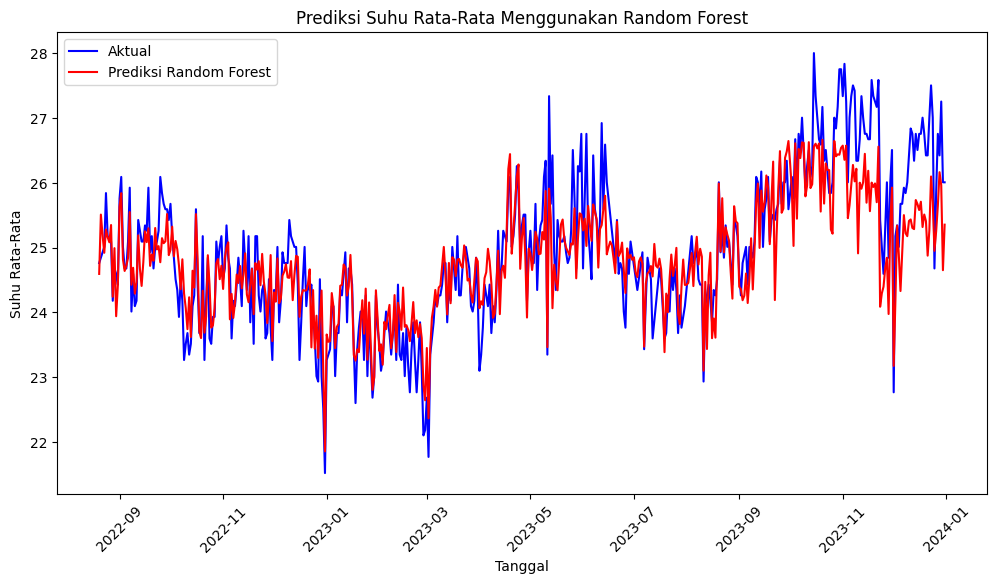

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(cuaca.index[train_size:], y_test_rescaled, label='Aktual', linestyle='-', color='blue')
plt.plot(cuaca.index[train_size:], y_pred_rescaled, label='Prediksi Random Forest', linestyle='-', color='red')
plt.xlabel("Tanggal")
plt.ylabel("Suhu Rata-Rata")
plt.title("Prediksi Suhu Rata-Rata Menggunakan Random Forest")
plt.legend()
plt.xticks(rotation=45)
plt.show()